# 1 Dimensional Model

##### Back to [Main](../../PackageInfo.ipynb)

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from geobipy import StatArray
from geobipy import Model1D
import matplotlib.pyplot as plt
import numpy as np
import h5py
from geobipy import hdfRead

### Make a test model with 10 layers, and increasing parameter values

In [3]:
par = StatArray(np.linspace(0.01, 0.1, 10), "Conductivity", "$\\frac{S}{m}$")
thk = StatArray(np.arange(1, 11))
mod = Model1D(parameters=par, thickness=thk, hasHalfspace=False)

In [4]:
mod.summary()

1D Model: 
Name:  # of Cells
    Units: 
    Shape: (1,)
   Values: [10]
No attached prior 
No attached proposal 
Top of the model: [0.]
Name:  Thickness
    Units: m
    Shape: (10,)
   Values: [ 1.  2.  3. ...  8.  9. 10.]
No attached prior 
No attached proposal 
Name:  Conductivity
    Units: $\frac{S}{m}$
    Shape: (10,)
   Values: [0.01 0.02 0.03 ... 0.08 0.09 0.1 ]
No attached prior 
No attached proposal 
Name:  Depth
    Units: m
    Shape: (10,)
   Values: [ 1.  3.  6. ... 36. 45. 55.]
No attached prior 
No attached proposal 



## Randomness and Model Perturbations
We can make the 1D model perturbable by assigning minimum and maximum layer depths, a maximum number of layers, and a probability wheel describing the relative probabilities of either creating a layer, deleting a layer, moving an interface, or doing nothing.

In [5]:
prng = np.random.RandomState()
# Assign probabilities to the model layers
# They are the cumulative probability of life-death-perturb-doNothing
mod.makePerturbable(pWheel=[0.5, 0.05, 0.15, 0.1], minDepth=1.0, maxDepth=150.0, maxLayers=30, prng=prng)
# We can then perturb the layers of the model
perturbed,option,value = mod.perturb()

<IPython.core.display.Javascript object>


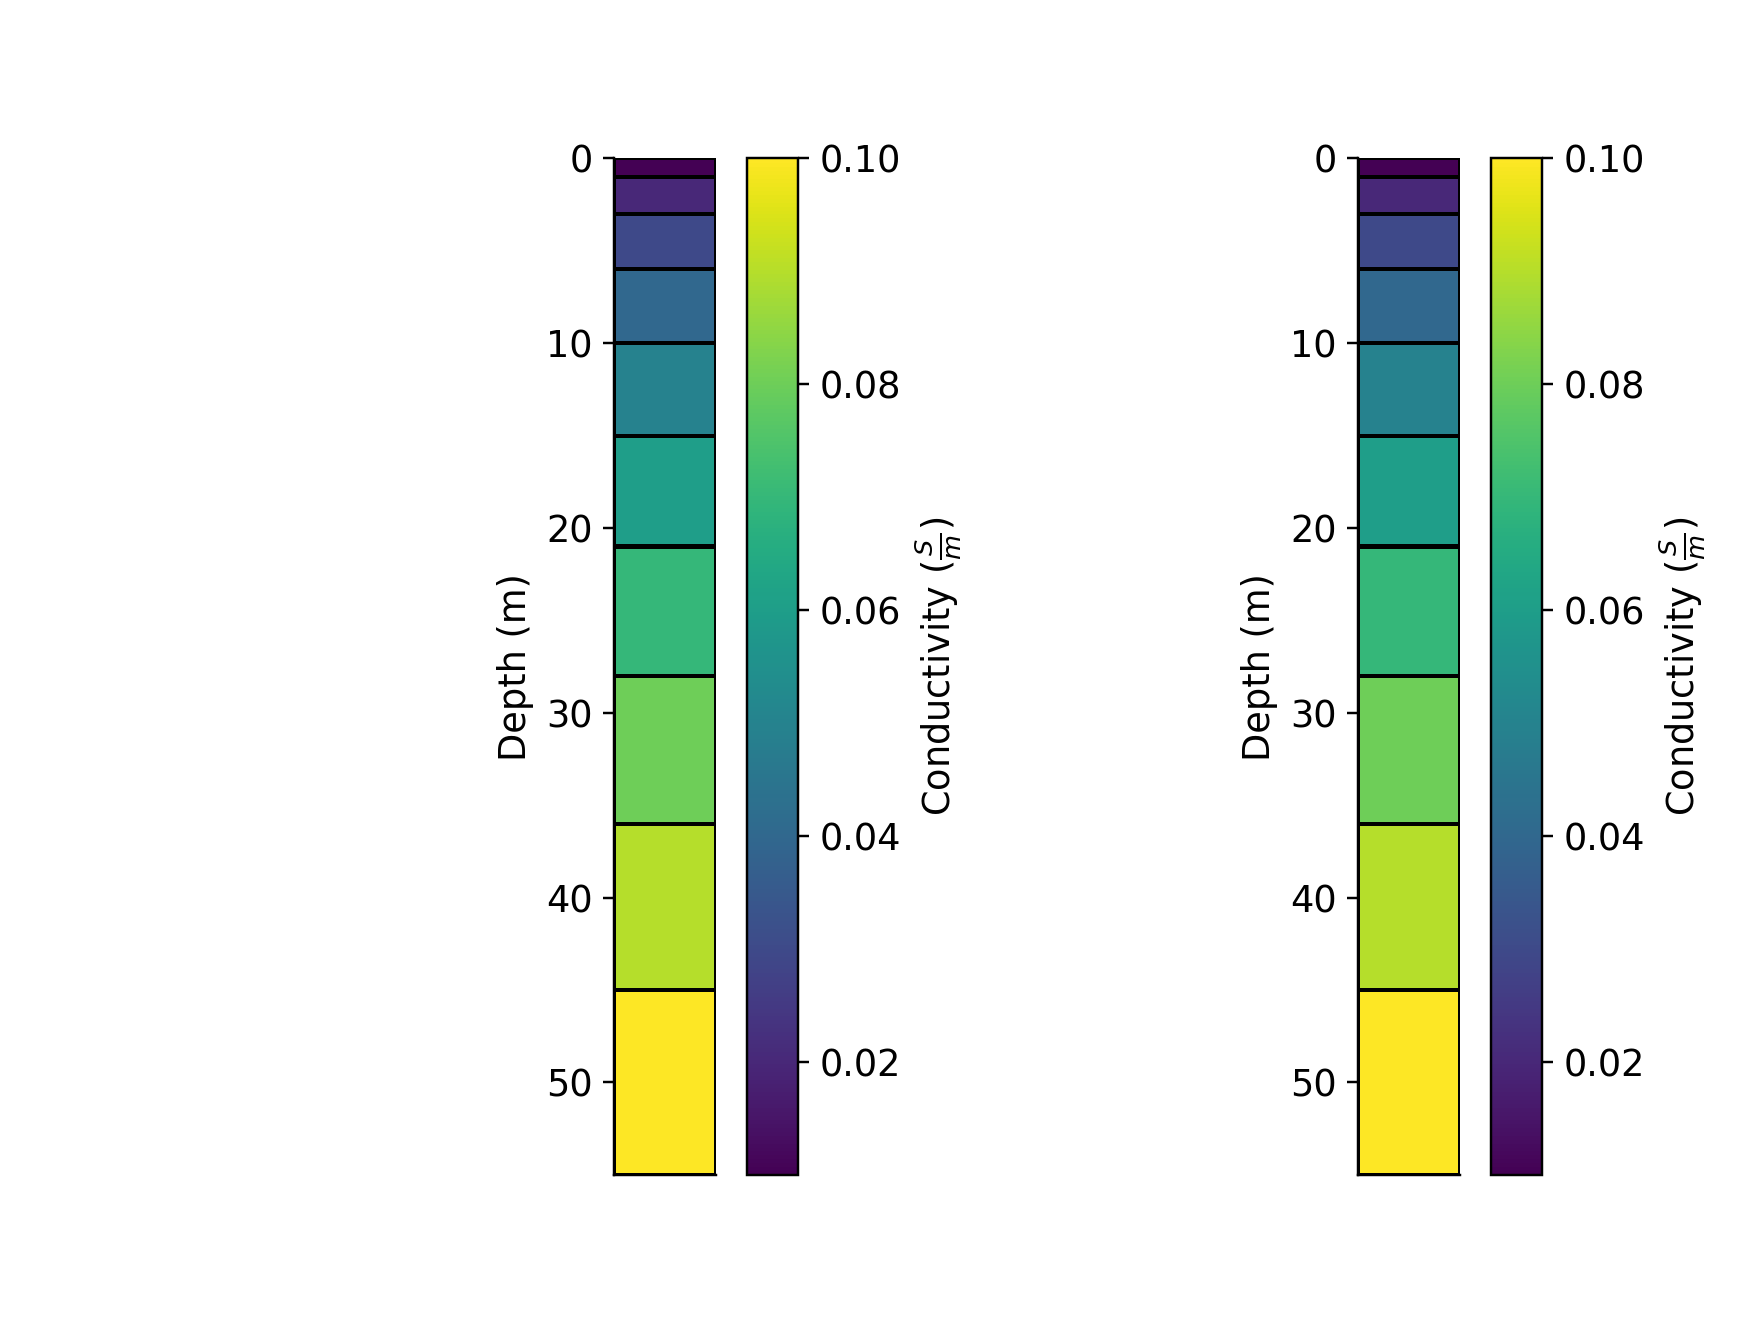

In [6]:
plt.figure(figsize=(8,6))
plt.subplot(121)
mod.pcolor(grid=True)
plt.subplot(122)
perturbed.pcolor(grid=True)
plt.savefig('Perturbed.png', dpi=200, figsize=(8,6))

<IPython.core.display.Javascript object>


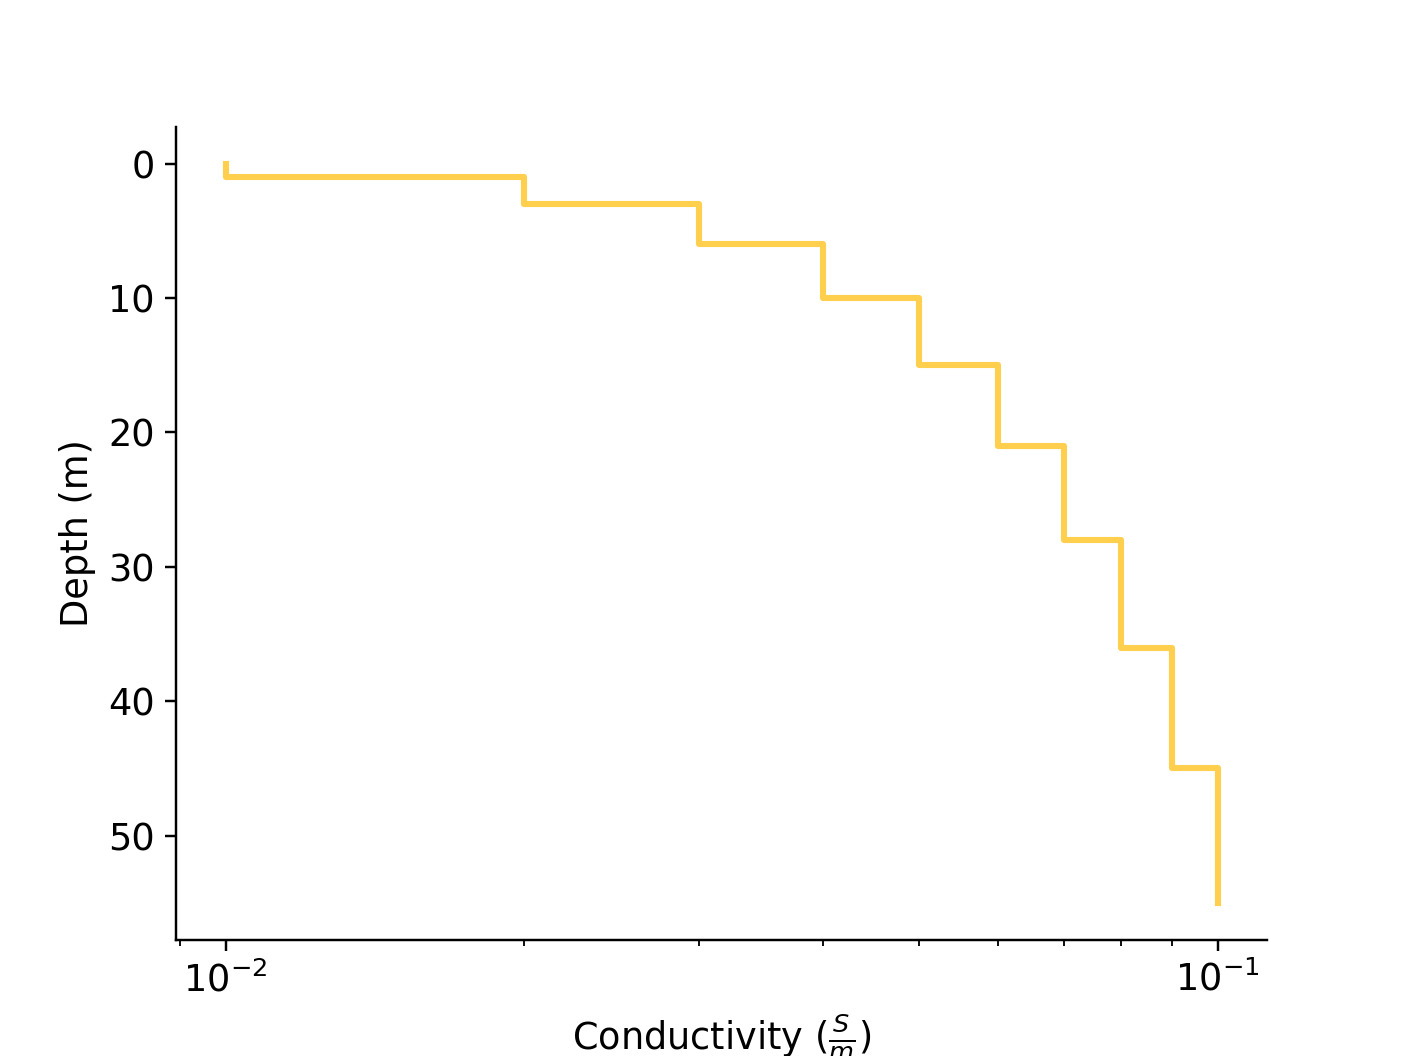

In [7]:
plt.figure()
mod.plot(flipY=True, xscale='log')

#### We can evaluate the prior of the model

In [8]:
try:
  tmp.priorProbability(True,True) # This is meant to fail here!
except:
  print('This will not work because no prior has been assigned')

This will not work because no prior has been assigned


#### This last command failed because we did not assign a prior distribution to the model parameters

In [9]:
# Set priors on the depth interfaces, given a number of layers
mod.depth.setPrior('Order',mod.minDepth,mod.maxDepth,mod.minThickness,30)
# To include priors on the parameter and change in the parameter, we need to assign their priors
# Assign a multivariate normal distribution that is logged to the conductivities
mod.par.setPrior('MvNormalLog',np.log(0.004),np.log(11.0), prng=prng)
# Assign a prior to the derivative of the model
mod.dpar.setPrior('MvNormalLog',0.0,np.float64(1.5), prng=prng)
# We can evaluate the prior of the model using depths only
print('Probability of the Model given its priors: ', mod.priorProbability(False,False))
# Or with priors on its parameters, and parameter gradient with depth.
print('Probability of the Model given its priors: ', mod.priorProbability(True,True))

Probability of the Model given its priors:  [-5.54467396]
Probability of the Model given its priors:  [-44.7423986]


#### Evaluating the prior uses the probability of the parameter distributions

In [10]:
# Evaluate the probability for these depths
print(mod.depth.probability(mod.nCells))

[0.1133383]


## Writing and reading with HDF5

### Write to a HDF5 file

In [11]:
with h5py.File('Model1D.h5','w') as hf:
    mod.toHdf(hf,'Model1D')

### Read from the file

In [12]:
ModNew=hdfRead.readKeyFromFiles('Model1D.h5','/','Model1D')

<IPython.core.display.Javascript object>


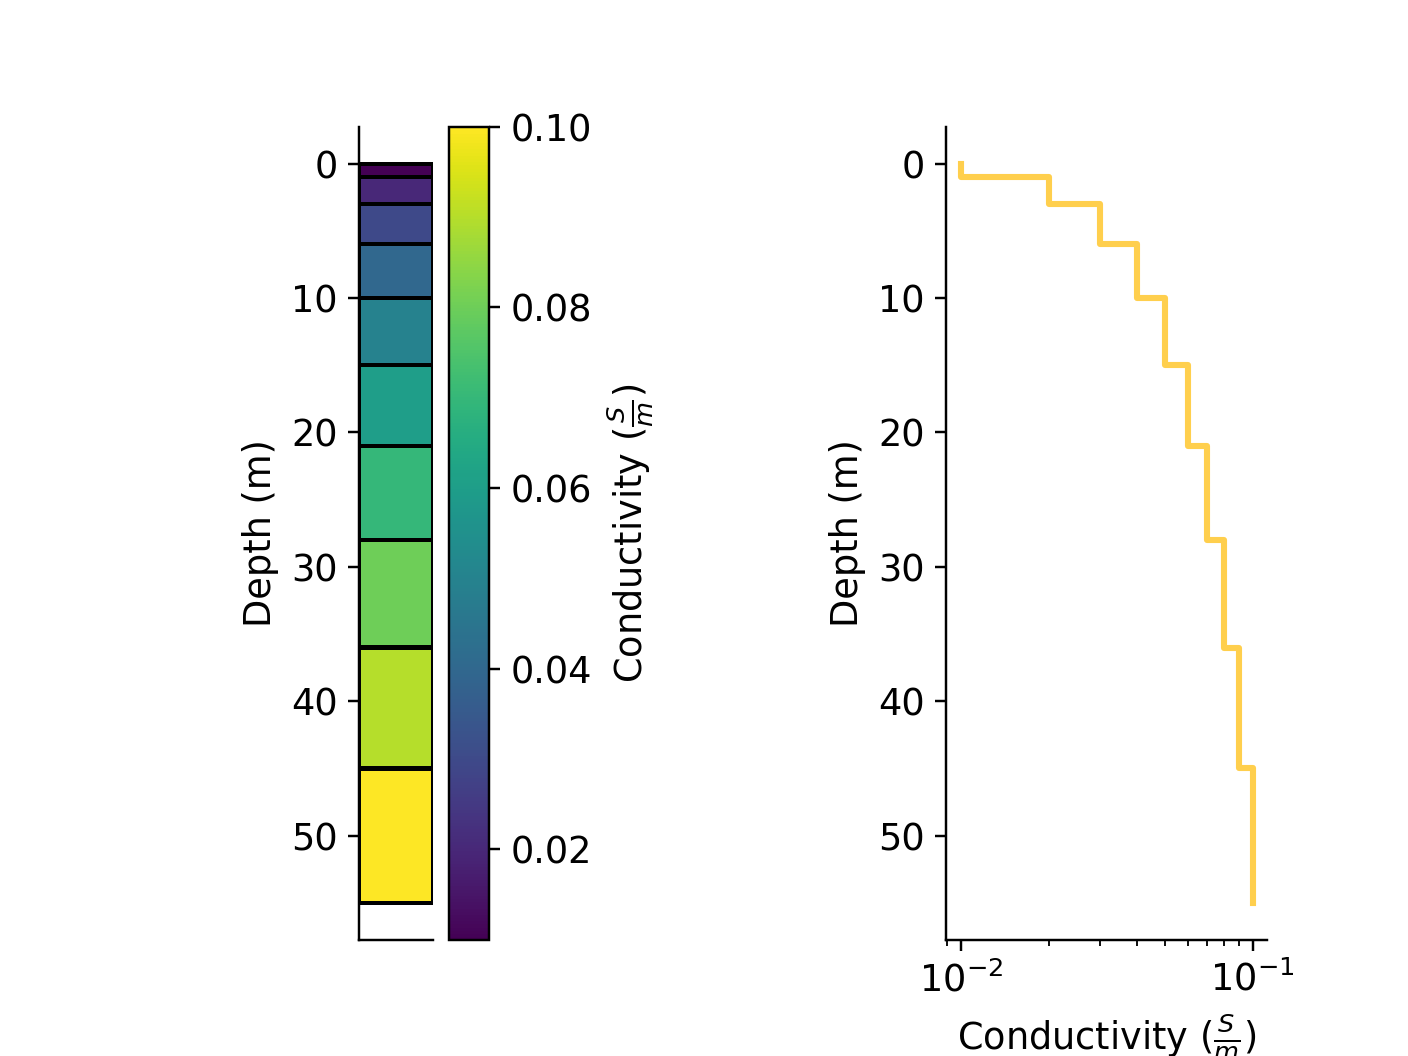

In [13]:
plt.figure()
ax = plt.subplot(131)
ModNew.pcolor(grid=True)
ax = plt.subplot(133, sharey = ax)
ModNew.plot(flipY=False)

### Creating memory in HDF5 to accomodate multiple models

In [14]:
# Create an initial Model class with enough layers to hold as many layers as we expect. (an upper bound)
tmp = Model1D(nCells=20)

# Open the file 
f = h5py.File('Model1D.h5','w')

# Create the memory using the temporary model with space for 2 models.
tmp.createHdf(f, myName='test', nRepeats=2)

# Write mod and perturbed to different entries in the HDF5 file
mod.writeHdf(f, 'test', index=0)
perturbed.writeHdf(f, 'test', index=1)

# Close the file
f.close()

### Reading from a HDF5 file with multiple models

In [15]:
# Special read functions
from geobipy import hdfRead
# Open the file
f = h5py.File('Model1D.h5', 'r')
# Read the Model1D from the file
tmp = hdfRead.readKeyFromFile(f, fName='Model1D.h5', groupName='/', key='test', index=1)
f.close()

### Creating a hitmap and adding a 1D model to it

In [16]:
from geobipy import Hitmap2D
x = StatArray(np.logspace(-3, -0, 100), name='Parameter')
y = StatArray(np.linspace(0.0, 60.0, 100), name='Depth', units='m')
Hit = Hitmap2D(xBins=x, yBins=y)

#### If we perturb a model multiple times, we can add each model to the hitmap

In [17]:
perturbed.addToHitMap(Hitmap=Hit)
for i in range(100):
    perturbed,option,value = perturbed.perturb()
    perturbed.addToHitMap(Hitmap=Hit)

<IPython.core.display.Javascript object>


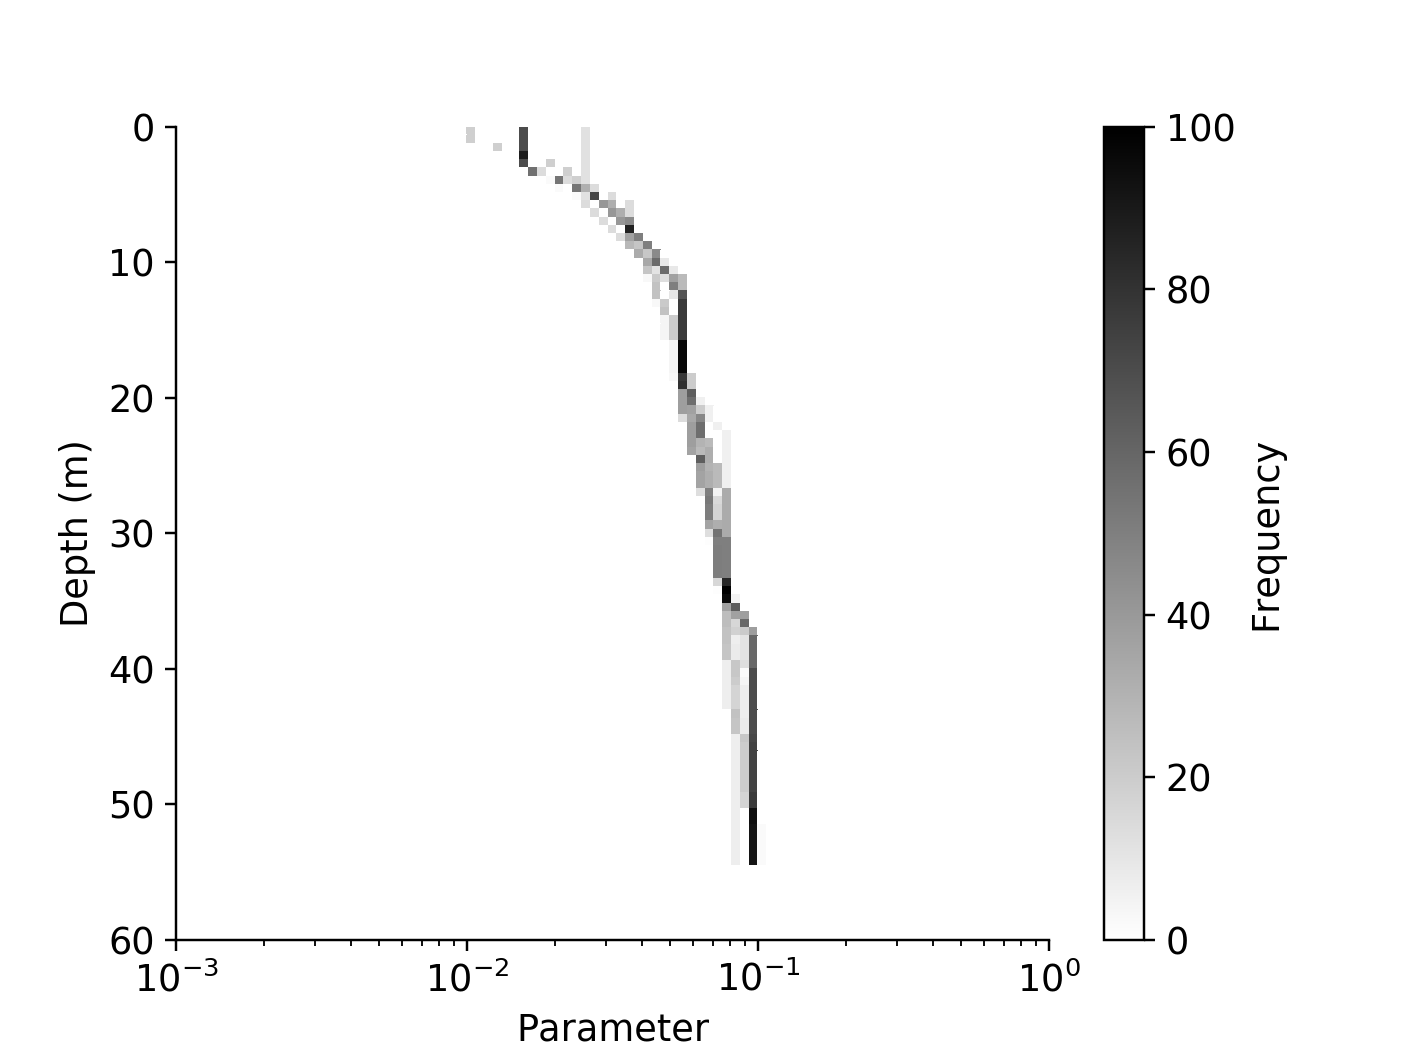

In [18]:
plt.figure()
Hit.pcolor(flipY=True, xscale='log', cmap='gray_r')

### We can access and plot the elements of model. The parameters are an [StatArray](../../Base/StatArray_Class.ipynb)

<IPython.core.display.Javascript object>


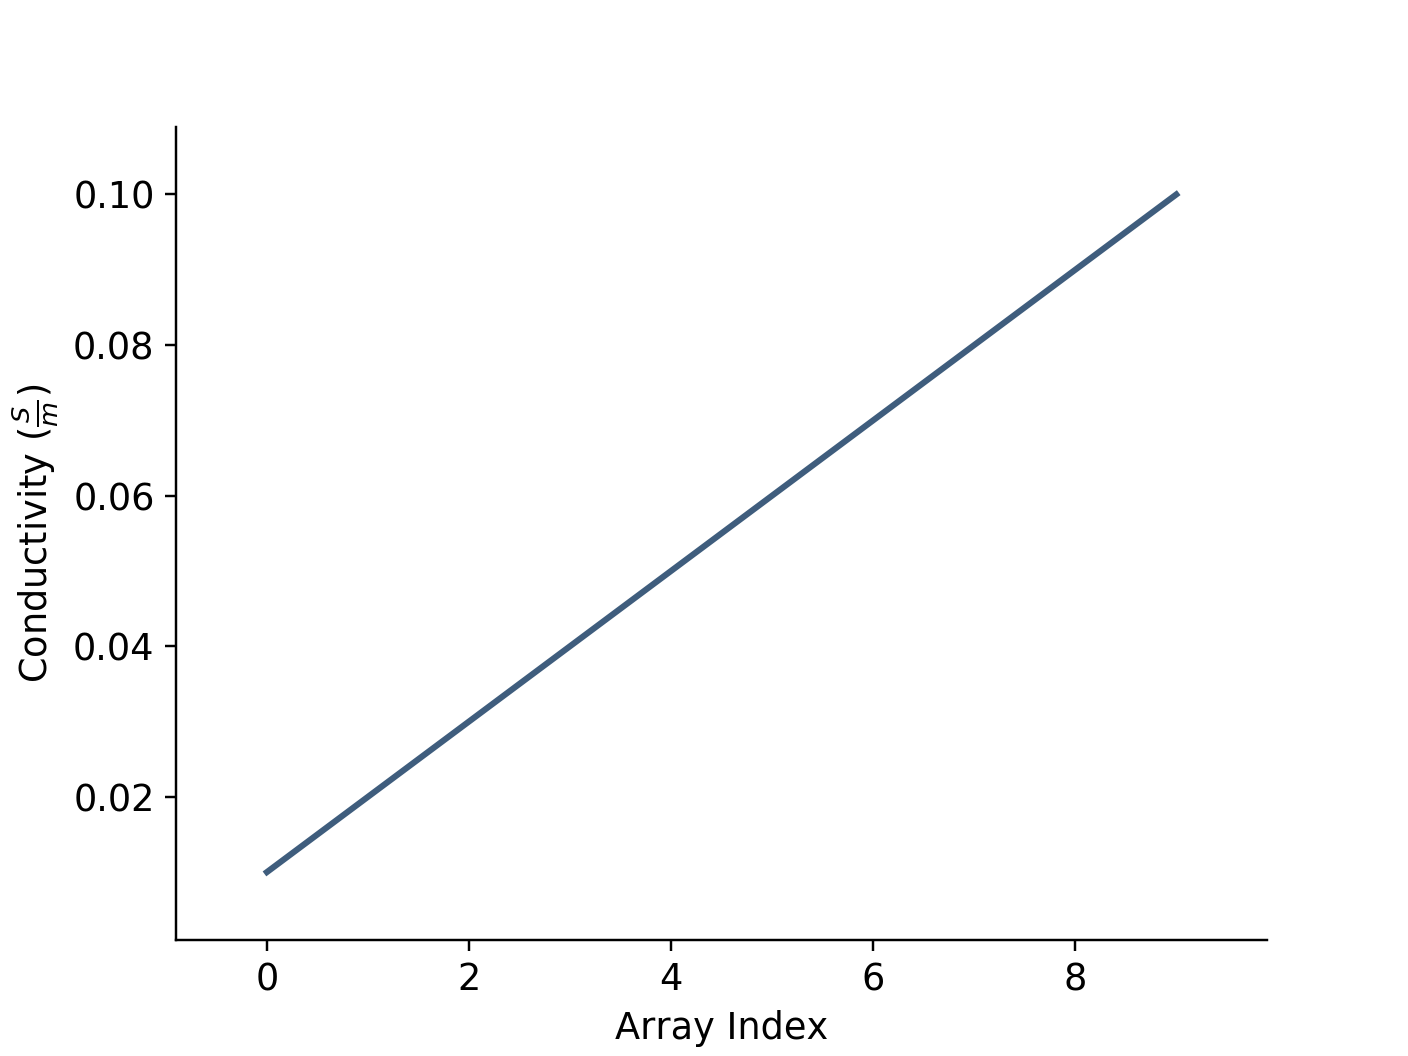

In [19]:
plt.figure()
mod.par.plot()

### Or we can plot the 1D model as coloured blocks

<IPython.core.display.Javascript object>


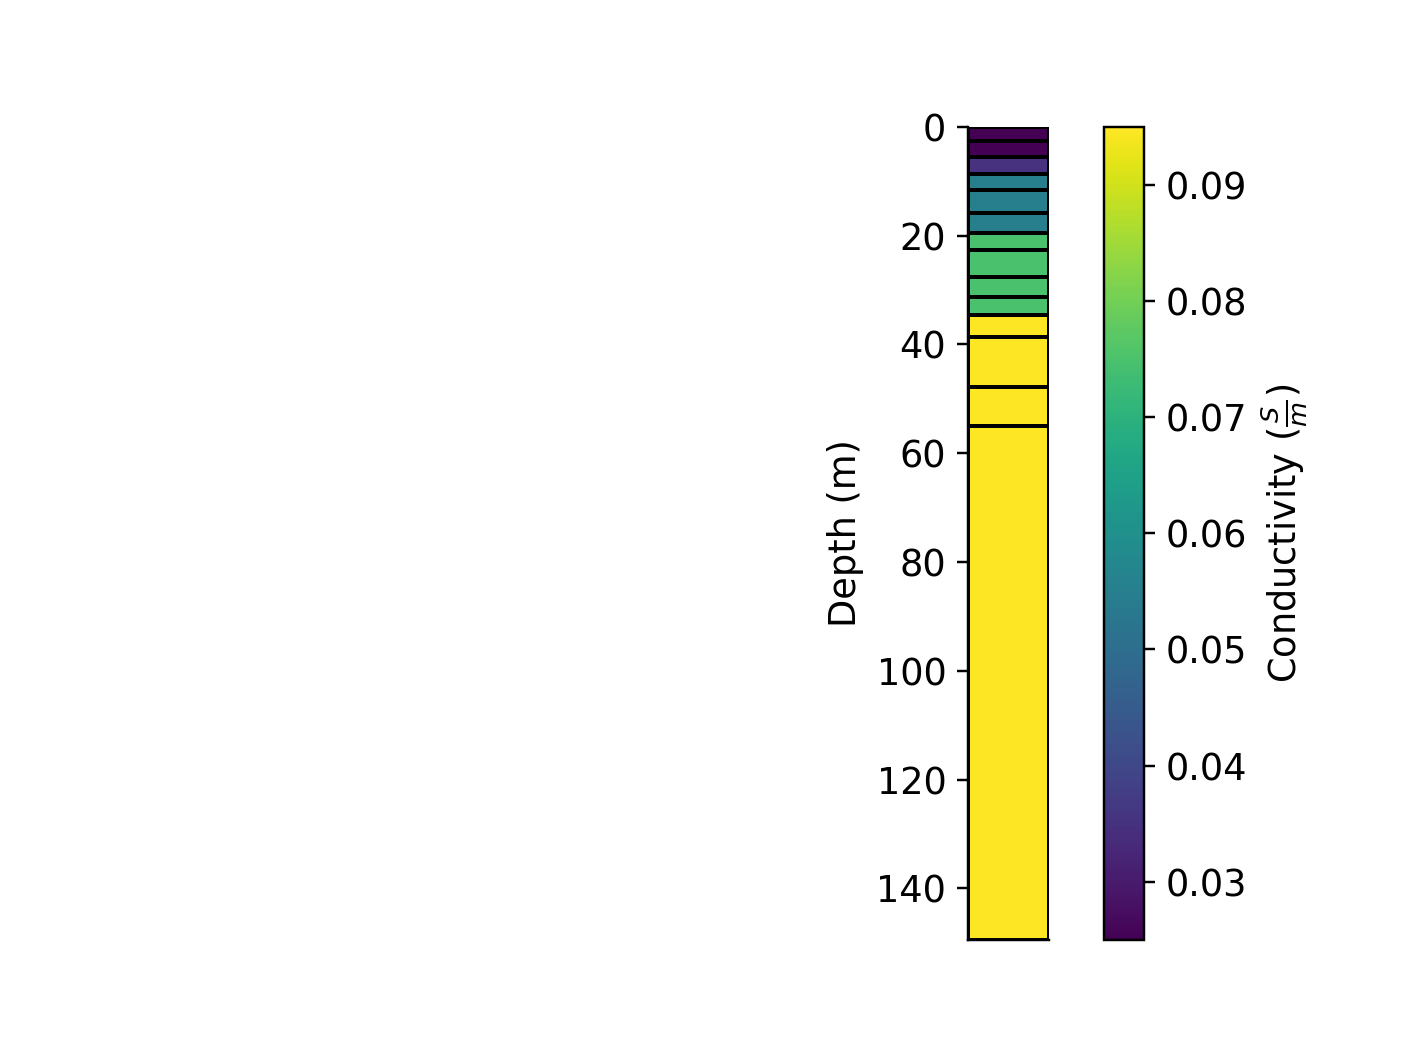

In [20]:
plt.figure()
perturbed.pcolor(grid=True)